In [64]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
from scipy import stats
import scikit_posthocs

from Bio import SeqIO
from glob import glob
import os
import re

In [3]:
colors = ['#1b9e77','#d95f02','#7570b3','#a6761d','#e7298a','#e6ab02','#666666','#66a61e']

Started this notebook freshly in python with all final data, once complete, delete most of the R notebook to avoid confusion (keep final heatmap)

Ideally, combine all tables here instead of manually in google sheet, to avoid errors.

# metagenome stats summary

## Load and merge tables

In [4]:
# read summary table and contamination table
summary_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/tables/summary_stats_table_060623.csv') # downloaded from manually compiled google sheet
metag_contam_info = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/tables/all_contam_report_060623.txt', sep='\t') # based on concatenated contamination reports from find_contams.py
metag_contam_info = metag_contam_info[metag_contam_info.sample_name != 'sample_name']

# read flow cytometry data table
fcm = pd.read_csv('/Users/rosekantor/data/awtp2/amplicon_16S/fcm_data_geomean.tsv', sep='\t')
fcm.loc[fcm.location_code == 'influent', 'location_code'] = 'WW_3ary'
fcm['sample_id'] = fcm.location_code + "_" + fcm.day.astype('str')

# merge summary, contam, and fcm into one df and set categories for plotting
summary_df = summary_df.merge(metag_contam_info, how='outer', on='sample_name')
summary_df = summary_df.merge(fcm, how='left', on='sample_id')

# filter out samples that were not included in metagenomics, adjust types, add categories for plotting
summary_metag_df = summary_df[~summary_df.assembly_size_mbp.isna()].copy()
summary_metag_df.perc_cov = summary_metag_df.perc_cov.astype('float')
summary_metag_df.total_length = summary_metag_df.total_length.astype('float')
summary_metag_df.Location = pd.Categorical(summary_metag_df.Location, ordered=True, categories=('WW_3ary', 'BAC', 'MF_combined', 
                                                                                    'RO_2stage', 
                                                                                    'RO_BF_retentate_scrapings', 'RO_BF_separator'))

# create column showing assembly size in Mbp (including contigs >1kb)
summary_metag_df['assembly_size_1kb_mbp'] = summary_metag_df.total_length / 1000000

## plots

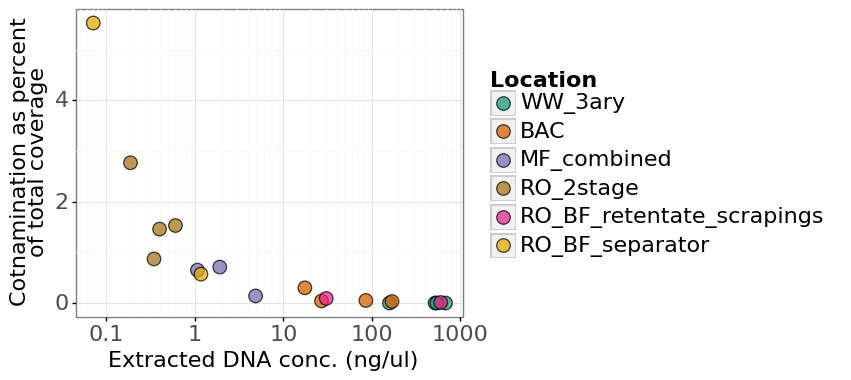

<ggplot: (346041727)>

In [5]:
# explore %contamination vs DNA extraction yield
plt = (ggplot(summary_metag_df, aes(x='DNA_ng_per_ul', y='perc_cov', fill='Location'))+
geom_point(size=5, color='black', alpha=0.75)+
scale_fill_manual(values=colors)+
scale_x_log10()+
xlab('Extracted DNA conc. (ng/ul)')+
ylab('Cotnamination as percent\nof total coverage')+
theme_bw()+
theme(figure_size=(5,4),
      axis_text_x=element_text(size=16),
      axis_text_y=element_text(size=16),
      axis_title=element_text(size=16),
      legend_text=element_text(size=16),
      legend_title=element_text(size=16, weight='bold')))
display(plt)
#ggsave(plt, '/Users/rosekantor/data/awtp2/metagenomics/figures/dna_vs_contam.svg')

# RO bulk dRep MAGs anvio summary table

In [14]:
#df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_RO2_BULK/RO2_BULK_derep_refined_MAGs_anvio_summary.csv')

In [ ]:
# df_info = df[['MAG name', 'family/order', 'Deepest classification', 'length Mbp',
#        'Contig count', 'N50', '%GC', 'Completeness', 'Contamination']].copy()

# df_abund = df[['MAG name', 'sample_3', 'sample_4', 'sample_5', 'sample_6']].copy()

# df_abund = df_abund.rename(columns={'sample_3':'Day 12', 'sample_4':'Day 26', 
#                         'sample_5':'Day 61', 'sample_6':'Day 91'})

In [ ]:
# order = df_abund['MAG name'].to_list()
# order.reverse()
# df_abund['MAG name'] = pd.Categorical(df_abund['MAG name'], ordered=True, categories=order)

In [ ]:
# df_abund_melt = df_abund.melt(id_vars='MAG name', value_name='% rel. abund.', var_name='Sample day')

In [ ]:
# plt = (ggplot(df_abund_melt, aes(y='MAG name', x='Sample day', fill='% rel. abund.'))+
#  geom_tile()+
#  scale_fill_continuous(trans='log10')+
#  theme_bw()+
#  theme(figure_size=(2,10),
#       axis_text_y=element_blank(),
#       axis_title_y=element_blank(),
#       axis_text_x=element_text(size=16, angle=45, hjust=1),
#       axis_title_x=element_blank())
# )

# display(plt)

# ggsave(plt, '/Users/rosekantor/data/awtp2_metagenomics/figures/drep_RO_abund_heatmap.svg')

# All Membrane dRep MAGs

In [6]:
# read tables
checkm_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/genomeInfo.csv')
tax_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/gtdbtk.bac120.summary.tsv', sep='\t')
anvio_sum_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/bins_summary.txt', sep='\t')
bins_renamed_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_info.tsv', sep='\t')
                              
# select columns from each table
checkm_df.genome = checkm_df.genome.str.extract(r'(.*).fa') # genome name ends in .fa, remove before merge
checkm_df = checkm_df[['genome', 'completeness', 'contamination', 'strain_heterogeneity']]
tax_df = tax_df[['user_genome', 'classification']]
bins_renamed_df = bins_renamed_df[['user_genome', 'sensible_name']]
# extract taxonomy
# tax_df[['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']] = tax_df.classification.str.extract(r'd__(.*);p__(.*);c__(.*);o__(.*);f__(.*);g__(.*);s__(.*)')

In [7]:
# merge tables
mags_df = tax_df.merge(checkm_df, how='left', left_on='user_genome', right_on='genome')
# merge in the manual renamed bins
mags_df = mags_df.merge(bins_renamed_df, on='user_genome', how='left')

# change bin names to match those in the anvio table before second merge
mags_df['genome'] = mags_df['genome'].str.replace('.', '_', regex=False)
mags_df['genome'] = mags_df['genome'].str.replace('-', '_', regex=False)

mags_df = mags_df.merge(anvio_sum_df, how='outer', left_on='genome', right_on='bins')
mags_df = mags_df.drop(columns=['genome', 'user_genome'])

In [8]:
# extract taxonomy name from gtdb for each MAG - want the family level name (or maybe species?)
# drop domain, phylum, and species - keep class, order, family; sometimes phylum is important
mags_df['short_taxonomy'] = mags_df.classification.str.extract(r';(c_.*);s_.*')
mags_df['phylum'] = mags_df.classification.str.extract(r';p__(.*);c__.*')
mags_df['short_taxonomy'] = mags_df['short_taxonomy'].str.replace('__','_')

In [9]:
mags_tax = mags_df[['bins', 'short_taxonomy', 'phylum', 'sensible_name']].copy()

## Calculate normalized coverage for each bin in each sample

In [10]:
# import coverage and mask on detection > 0.10 (genome breadth of coverage over 10% of length)
# require ≥ 1x avg coverage across the covered region

anvio_cov_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/bins_across_samples/mean_coverage_Q2Q3.txt', 
                           sep='\t', index_col=0)

anvio_detect_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/bins_across_samples/detection.txt',
                              sep='\t', index_col=0)

anvio_cov_df = anvio_cov_df[(anvio_cov_df/anvio_detect_df)>=1]

mask = anvio_detect_df > 0.10

anvio_cov_df = anvio_cov_df[mask]

In [11]:
anvio_cov_df = anvio_cov_df.reset_index()
anvio_cov_df = anvio_cov_df.melt(id_vars='bins', var_name='sample_name', value_name='coverage')
anvio_cov_df = anvio_cov_df.merge(summary_df, how='left', on='sample_name')

# order samples for plotting
sample_order = ['WW_3ary_12','WW_3ary_26','WW_3ary_61','WW_3ary_91',
                'BAC_12','BAC_26','BAC_61','BAC_91',
                'MF_combined_26','MF_combined_61','MF_combined_91',
                'RO_BF_retentate_scrapings_118', 'RO_BF_separator_118',
                'RO_BF_retentate_scrapings_328','RO_BF_separator_328',
                'RO_2stage_12','RO_2stage_26','RO_2stage_61','RO_2stage_91']

anvio_cov_df.sample_id = pd.Categorical(anvio_cov_df.sample_id, ordered = True, categories = sample_order)

In [12]:
# calculate median normalized coverage 
# norm_cov = (median(total seq) * MAG cov / total seq)

anvio_cov_df.perc_cov = pd.to_numeric(anvio_cov_df.perc_cov)
anvio_cov_df['contam_inflation_factor'] = 100 / (100 - anvio_cov_df.perc_cov)
anvio_cov_df['normalized_cov'] = np.median(anvio_cov_df.total_seq_Gb) * \
                                 (anvio_cov_df.coverage / anvio_cov_df.total_seq_Gb) * \
                                 anvio_cov_df.contam_inflation_factor

In [13]:
# calculate RPKM (another way of normalizing coverage)
# RPKM = reads per kilobase of genome per million reads
# cov = reads per bp
# RPKM = (cov * 1000)*(1,000,000 / total reads)

anvio_cov_df['rpkm'] = (anvio_cov_df.coverage * 1000) * (1000000 / anvio_cov_df.total_seq_Gb) * \
                                 anvio_cov_df.contam_inflation_factor

In [14]:
# add taxonomy
anvio_cov_df = anvio_cov_df.merge(mags_tax, on='bins', how='left')

In [191]:
len(anvio_cov_df.bins.unique())

143

In [312]:
# save to file for plotting clustered heatmap in R
# anvio_cov_df.to_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_FiltNormCov_for_plotting.tsv', 
#           sep='\t', index=False)

## Identify which bins were at significantly higher abundance in MF vs RO samples

In [34]:
# most bins are only present in MF or RO but not in both
# make lists of MF-only bins and RO-only bins
# fill na with zero before calculating kruskal wallis

In [16]:
cov_MF_RO_df = anvio_cov_df[anvio_cov_df.Location.isin(['MF_combined', 'RO_2stage'])].copy()
cov_MF_RO_df = cov_MF_RO_df[['bins', 'Location', 'normalized_cov']]
cov_MF_RO_df.normalized_cov = cov_MF_RO_df.normalized_cov.fillna(0)

enriched_df = []

for bin, df in cov_MF_RO_df.groupby(['bins']):
    mf = df[df.Location=='MF_combined'].normalized_cov.values
    ro = df[df.Location=='RO_2stage'].normalized_cov.values
    
    enriched_in = None
    
    if np.mean(mf) > np.mean(ro):
        enriched_in = 'MF_combined'
        
    elif np.mean(mf) < np.mean(ro):
        enriched_in = 'RO_2stage'
    
    U1, p = stats.mannwhitneyu(mf, ro)
    
    
    enriched_df.append([bin, enriched_in, p, np.mean(mf), np.mean(ro)])

enriched_df = pd.DataFrame.from_records(enriched_df, columns=['bins', 'enriched_in', 'p', 'mean_cov_mf', 'mean_cov_ro'])

In [31]:
# checking that this makes sense
#enriched_df.sort_values(by='p')
display(enriched_df.shape)
display(enriched_df[(enriched_df.mean_cov_mf>0) | (enriched_df.mean_cov_ro>0)].shape)
display(enriched_df[(enriched_df.p < 0.05)].shape)

(143, 5)

(89, 5)

(35, 5)

Conclusion: maybe we should include all bins that were 0 in one group (MF or RO), rather than only bins with p<0.05. Especially given that there are only 3 samples of MF and 4 samples of RO, which makes it hard to get a significant p-value.

In [36]:
# export to anvi_compute_metabolic_enrichment
groups_for_anvio = enriched_df[(enriched_df.p < 0.05)][['bins', 'enriched_in']]
groups_for_anvio.to_csv('~/data/awtp2/metagenomics/dRep_membranes/groups_enriched.txt', sep='\t', index=False)

# avg rank abundance

In [50]:
anvio_cov_df

,bins,sample_name,coverage,sample_id,Location,date,DNA_ng_per_ul,ASVs,total_seq_Gb,assembly_size_mbp,...,day,location_code,TCC,ICC,contam_inflation_factor,normalized_cov,rpkm,short_taxonomy,phylum,sensible_name
0,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_15,AWTP2_SAMPLE_BAC_BULK_2,NaN,BAC_12,BAC,9/26/2017,17.500,383.0,29.5,1340.9,...,12.0,BAC,786197.44299,571925.263175,1.003009,NaN,NaN,c_Oligoflexia;o_Oligoflexales;f_RGVZ01;g_CAMDKS01,Bdellovibrionota,o__Oligoflexales
1,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_40_sub,AWTP2_SAMPLE_BAC_BULK_2,1.738644,BAC_12,BAC,9/26/2017,17.500,383.0,29.5,1340.9,...,12.0,BAC,786197.44299,571925.263175,1.003009,0.484738,5.911442e+07,c_Alphaproteobacteria;o_Rickettsiales;f_UBA300...,Pseudomonadota,o__Rickettsiales_2
2,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_58,AWTP2_SAMPLE_BAC_BULK_2,NaN,BAC_12,BAC,9/26/2017,17.500,383.0,29.5,1340.9,...,12.0,BAC,786197.44299,571925.263175,1.003009,NaN,NaN,c_Bdellovibrionia;o_Bdellovibrionales;f_Bdello...,Bdellovibrionota,f__Bdellovibrionaceae
3,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_61,AWTP2_SAMPLE_BAC_BULK_2,NaN,BAC_12,BAC,9/26/2017,17.500,383.0,29.5,1340.9,...,12.0,BAC,786197.44299,571925.263175,1.003009,NaN,NaN,c_UBA1018;o_UBA1018;f_UBA1018;g_JAEUWC01,Bdellovibrionota,p__Bdellovibrionota_2
4,AWTP2_SAMPLE_MFCOMB_BULK_1_concoct_71,AWTP2_SAMPLE_BAC_BULK_2,NaN,BAC_12,BAC,9/26/2017,17.500,383.0,29.5,1340.9,...,12.0,BAC,786197.44299,571925.263175,1.003009,NaN,NaN,c_Alphaproteobacteria;o_Sphingomonadales;f_Sph...,Pseudomonadota,s__Sphingopyxis_terrae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,AWTP2_SAMPLE_RO2_BULK_6_metabat2_26105,AWTP2_SAMPLE_RO2_BULK_6,11.282747,RO_2stage_91,RO_2stage,12/14/2017,0.187,149.0,6.5,261.7,...,91.0,RO_2stage,238.65919,148.737493,1.028489,14.639124,1.785259e+09,c_Gammaproteobacteria;o_Burkholderiales;f_Burk...,Pseudomonadota,g__Undibacterium
2713,AWTP2_SAMPLE_RO2_BULK_6_metabat2_702,AWTP2_SAMPLE_RO2_BULK_6,8.046238,RO_2stage_91,RO_2stage,12/14/2017,0.187,149.0,6.5,261.7,...,91.0,RO_2stage,238.65919,148.737493,1.028489,10.439822,1.273149e+09,c_Actinomycetia;o_Mycobacteriales;f_Mycobacter...,Actinomycetota,s__Mycobacterium_fluoranthenivorans
2714,AWTP2_SAMPLE_RO2_BULK_6_vamb_3190,AWTP2_SAMPLE_RO2_BULK_6,135.615640,RO_2stage_91,RO_2stage,12/14/2017,0.187,149.0,6.5,261.7,...,91.0,RO_2stage,238.65919,148.737493,1.028489,175.958393,2.145834e+10,c_Gammaproteobacteria;o_Burkholderiales;f_Burk...,Pseudomonadota,s__Cupriavidus_metallidurans
2715,AWTP2_SAMPLE_RO2_BULK_6_vamb_3191,AWTP2_SAMPLE_RO2_BULK_6,11.854089,RO_2stage_91,RO_2stage,12/14/2017,0.187,149.0,6.5,261.7,...,91.0,RO_2stage,238.65919,148.737493,1.028489,15.380427,1.875662e+09,c_Bacteroidia;o_Sphingobacteriales;f_Sphingoba...,Bacteroidota,f__Sphingobacteriaceae


In [51]:
# get mean coverage of each bin in MF and RO and plot curves (drop bins if cov=0)
# use sensible bin name rather than original
cov_MF_RO_df = anvio_cov_df[anvio_cov_df.Location.isin(['MF_combined', 'RO_2stage'])].copy()
cov_MF_RO_df = cov_MF_RO_df[['sensible_name', 'Location', 'normalized_cov']]
cov_MF_RO_df.normalized_cov = cov_MF_RO_df.normalized_cov.fillna(0)

avg_cov_MF_RO_df = cov_MF_RO_df.groupby(['sensible_name', 'Location']).mean().reset_index()
avg_cov_MF_df = avg_cov_MF_RO_df[(avg_cov_MF_RO_df.Location=='MF_combined') & 
                                 (avg_cov_MF_RO_df.normalized_cov>0)].copy()
avg_cov_RO_df = avg_cov_MF_RO_df[(avg_cov_MF_RO_df.Location=='RO_2stage') & 
                                 (avg_cov_MF_RO_df.normalized_cov>0)].copy()

In [52]:
# set order for plotting
bin_order_MF = avg_cov_MF_df.sort_values('normalized_cov', ascending=False).sensible_name.to_list()
avg_cov_MF_df.sensible_name = pd.Categorical(avg_cov_MF_df.sensible_name, ordered=True, categories = bin_order_MF)

bin_order_RO = avg_cov_RO_df.sort_values('normalized_cov', ascending=False).sensible_name.to_list()
avg_cov_RO_df.sensible_name = pd.Categorical(avg_cov_RO_df.sensible_name, ordered=True, categories = bin_order_RO)

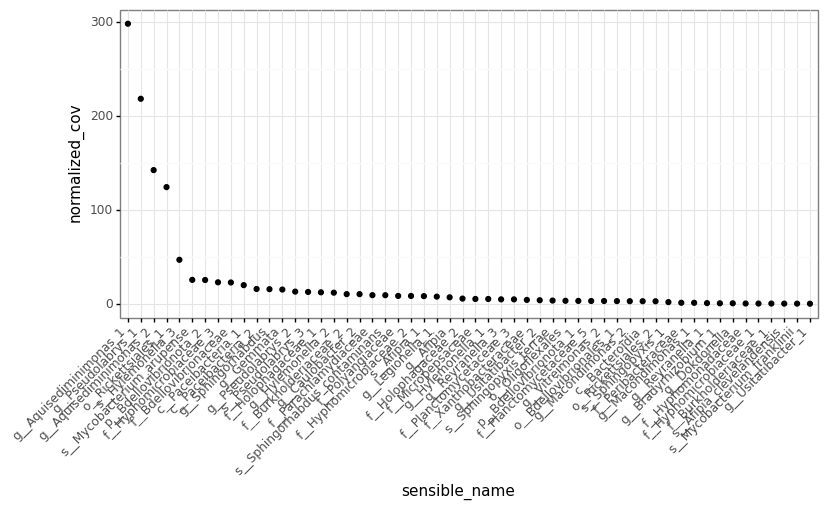

<ggplot: (350680339)>

In [61]:
(ggplot(avg_cov_MF_df, aes(x='sensible_name', y='normalized_cov'))+
    geom_point()+
    theme_bw()+
    theme(figure_size=(9,4), axis_text_x=element_text(angle=45, hjust=1)))

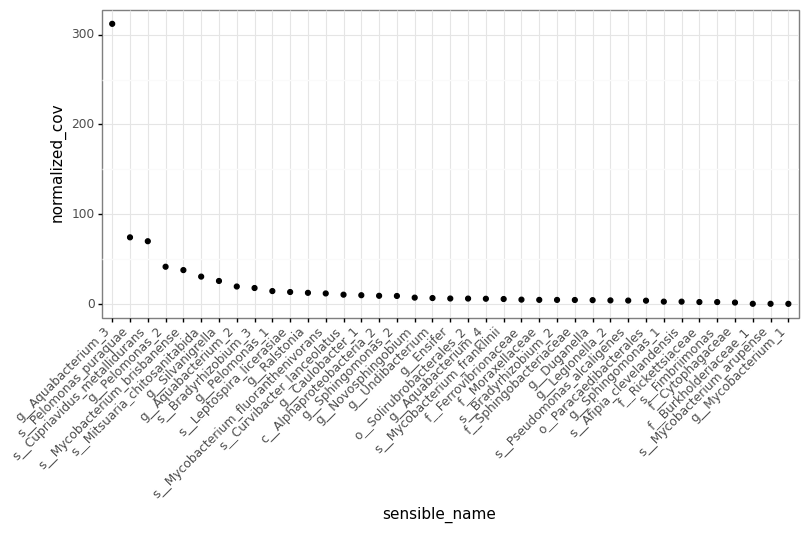

<ggplot: (350742763)>

In [62]:
(ggplot(avg_cov_RO_df, aes(x='sensible_name', y='normalized_cov'))+
    geom_point()+
    theme_bw()+
    theme(figure_size=(9,4), axis_text_x=element_text(angle=45, hjust=1)))

# Visualize virus mapping data

In [288]:
# collect accessions for all viruses downloaded as custom ref database and make a table
ref_db = []
for file in glob('/Users/rosekantor/data/awtp2/metagenomics/virus_refs/*_complete_genomes.fasta'):
    tax = os.path.basename(file)
    tax = re.split("_complete_genomes", tax)[0]
    for record in SeqIO.parse(file, "fasta"):
        ref_db.append([record.id, tax])
        
ref_db = pd.DataFrame.from_records(ref_db, columns=['accession', 'tax'])

ref_db.head()

,accession,tax
0,NC_001699.1,jc_polyomavirus
1,OR661738.1,jc_polyomavirus
2,OQ230875.1,jc_polyomavirus
3,OQ230876.1,jc_polyomavirus
4,OQ230877.1,jc_polyomavirus


In [244]:
# combine all readcount data from all samples
hits_df = []
for file in glob('/Users/rosekantor/data/awtp2/metagenomics/virus_mappings/*tsv'):
    samp = os.path.basename(file)
    samp = re.split("_virus_reads_mapped.tsv", samp)[0]
    df = pd.read_csv(file, sep='\t', names=['accession', 'len', 'mapped', 'unmapped'])
    df['sample_name'] = samp
    hits_df.append(df)
hits_df = pd.concat(hits_df)

# merge with reference taxonomy info df
hits_df = hits_df.merge(ref_db, on='accession', how='outer')

# drop zeros (rows with nothing mapped)
hits_df = hits_df[hits_df.mapped > 0]

# group and summarize hits by taxa within each sample
hits_grouped = hits_df.groupby(['sample_name', 'tax']).aggregate(total_mapped=('mapped','sum'), length=('len','max')).reset_index()
hits_grouped.sample_name = hits_grouped.sample_name.str.replace('-', '_') # replace to match names in summary_stats_df

# merge in the sample_id
summary_stats_df = pd.read_csv('/Users/rosekantor/data/awtp2/metagenomics/tables/summary_stats_table_060623.csv')
summary_stats_df = summary_stats_df[~summary_stats_df.total_seq_Gb.isna()] # drop samples that had 16S only
hits_grouped = pd.merge(hits_grouped, summary_stats_df, on='sample_name', how='left')
hits_grouped = hits_grouped[['sample_id', 'tax', 'total_mapped', 'length', 'total_seq_Gb']]
hits_grouped['perc_rel_abund'] = hits_grouped.total_mapped * 150 * 100 / (hits_grouped.total_seq_Gb * 1e9)

In [245]:
# order by sample_id for plotting

# order samples for plotting
sample_order = ['WW_3ary_12','WW_3ary_26','WW_3ary_61','WW_3ary_91',
                'BAC_12','BAC_26','BAC_61','BAC_91',
                'MF_combined_26','MF_combined_61','MF_combined_91',
                'RO_BF_retentate_scrapings_118', 'RO_BF_separator_118',
                'RO_BF_retentate_scrapings_328','RO_BF_separator_328',
                'RO_2stage_12','RO_2stage_26','RO_2stage_61','RO_2stage_91']

hits_grouped.sample_id = pd.Categorical(hits_grouped.sample_id, ordered = True, categories = sample_order)

tax_order = ['betapolyomavirus_hominis', 'jc_polyomavirus', 
             'human_mastadenovirus_A', 'human_mastadenovirus_B', 'human_mastadenovirus_C', 
             'human_mastadenovirus_D', 'human_mastadenovirus_E', 'human_mastadenovirus_F', 
             'human_mastadenovirus_G']
hits_grouped.tax = pd.Categorical(hits_grouped.tax, ordered=True, categories=tax_order[::-1])

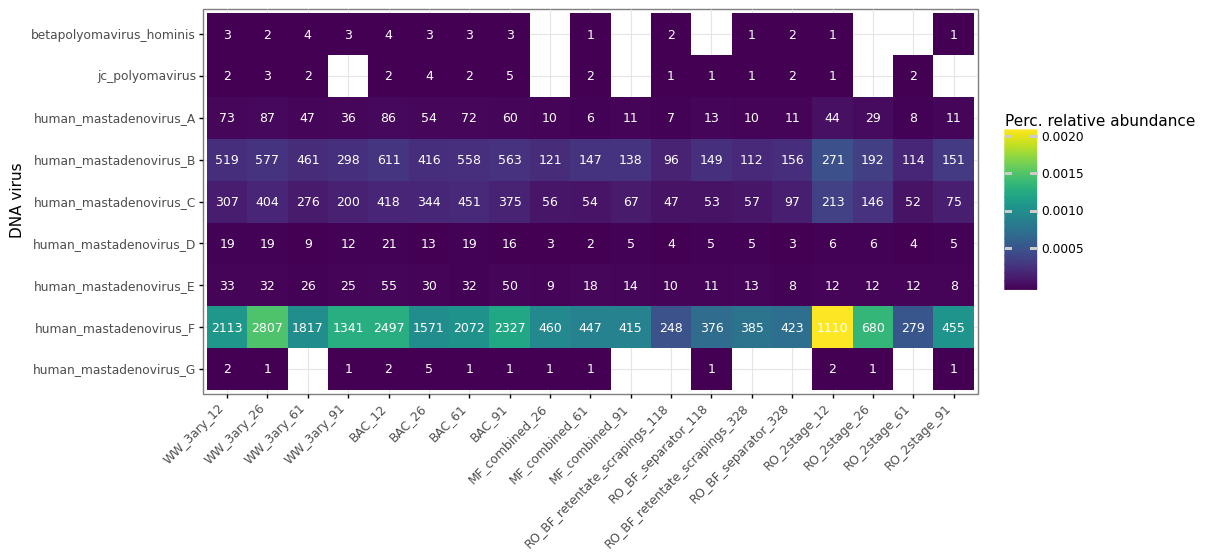

<ggplot: (379689099)>

In [259]:
(ggplot(hits_grouped, aes(x='sample_id', y='tax', fill='perc_rel_abund', label='total_mapped'))+
    geom_tile()+
    geom_text(color='white', size='9')+
    labs(fill='Perc. relative abundance')+
    scale_fill_continuous()+
    ylab('DNA virus')+
    xlab('')+
    theme_bw()+
    theme(
        axis_text_x=element_text(angle=45, hjust=1),
        figure_size=(10,5))
)

In [282]:
# combine all readcount data from all samples
hits_df = []
for file in glob('/Users/rosekantor/data/awtp2/metagenomics/virus_mappings/*cov.txt'):
    samp = os.path.basename(file)
    samp = re.split("_virus_reads_mapped.tsv", samp)[0]
    df = pd.read_csv(file, sep='\t')
    df['sample_name'] = samp
    hits_df.append(df)
hits_df = pd.concat(hits_df)

In [293]:
hits_df = hits_df.rename(columns={'#rname':'accession'})
hits_df[hits_df.numreads!=0].merge(ref_db, on='accession')


,accession,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,sample_name,tax
0,ON561778.1,1,34175,2,221,0.646672,0.008778,36.4,1,AWTP2_SAMPLE_INF_BULK_4-vs-polyomavirus_adenov...,human_mastadenovirus_F
1,OP255975.1,1,34184,2,240,0.702083,0.008776,37.0,1,AWTP2_SAMPLE_INF_BULK_4-vs-polyomavirus_adenov...,human_mastadenovirus_F
2,AB728839.1,1,34179,2,300,0.877732,0.008777,36.2,1,AWTP2_SAMPLE_INF_BULK_4-vs-polyomavirus_adenov...,human_mastadenovirus_F
3,ON815881.1,1,34200,2,300,0.877193,0.008772,34.5,1,AWTP2_SAMPLE_INF_BULK_3-vs-polyomavirus_adenov...,human_mastadenovirus_F
4,MT277585.1,1,36523,2,197,0.539386,0.007913,36.4,0,AWTP2_SAMPLE_RO2_BIOFILM-SEP_2-vs-polyomavirus...,human_mastadenovirus_C


## investigate mastadenovirus F hits in RO

In [272]:
# found the accession with max hits
hits_df[hits_df.mapped == hits_df.mapped.max()]
hits_df[hits_df.accession == 'OP174921.1'].sort_values('sample_name')

,accession,len,mapped,unmapped,sample_name,tax
39585,OP174921.1,34172,581,581,AWTP2_SAMPLE_BAC_BULK_2,human_mastadenovirus_F
39591,OP174921.1,34172,323,323,AWTP2_SAMPLE_BAC_BULK_3,human_mastadenovirus_F
39594,OP174921.1,34172,452,452,AWTP2_SAMPLE_BAC_BULK_4,human_mastadenovirus_F
39583,OP174921.1,34172,519,519,AWTP2_SAMPLE_BAC_BULK_5,human_mastadenovirus_F
39582,OP174921.1,34172,476,477,AWTP2_SAMPLE_INF_BULK_2,human_mastadenovirus_F
39593,OP174921.1,34172,648,648,AWTP2_SAMPLE_INF_BULK_3,human_mastadenovirus_F
39590,OP174921.1,34172,383,386,AWTP2_SAMPLE_INF_BULK_4,human_mastadenovirus_F
39584,OP174921.1,34172,312,313,AWTP2_SAMPLE_INF_BULK_5,human_mastadenovirus_F
39588,OP174921.1,34172,101,101,AWTP2_SAMPLE_MFCOMB_BULK_1,human_mastadenovirus_F
39581,OP174921.1,34172,128,128,AWTP2_SAMPLE_MFCOMB_BULK_2,human_mastadenovirus_F


In [281]:
with open('/Users/rosekantor/data/awtp2/metagenomics/virus_refs/mastadenovirus_F_OP174921_1.fasta', 'w') as f:
    for record in SeqIO.parse('/Users/rosekantor/data/awtp2/metagenomics/virus_refs/human_mastadenovirus_F_complete_genomes.fasta', "fasta"):
        if record.id == 'OP174921.1':
            f.write(f'>{record.id}\n{record.seq}')
f.close()

Most of these were ultra short reads. After excluding reads < 75 bp, concluded based on visualization of read mapping that all reads mapped to the same region, so they probably don't represent "true" detection of these viruses (see Evernote)

# InStrain and iRep results

In [205]:
instrain_df = []
for file in glob('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/instrain/*genome_info.tsv'):
    sample_id = os.path.basename(file)
    sample_id = re.split("_genome_info", sample_id)[0]
    df = pd.read_csv(file, sep='\t')
    df['sample_name'] = sample_id
    instrain_df.append(df)
        
instrain_df = pd.concat(instrain_df)
instrain_df = instrain_df.rename(columns={'genome':'bins'})

# add taxonomy and anvio info
instrain_df = anvio_cov_df.merge(instrain_df, on=['sample_name', 'bins'], how='right', suffixes=('_anv', '_ins'))
instrain_df = mags_df[['completeness', 'contamination', 'strain_heterogeneity', 'sensible_name', 'num_contigs']].merge(instrain_df, on='sensible_name', how='right')
instrain_df['scaffolds_per_mbp'] = instrain_df['true_scaffolds'] * 1e6 / instrain_df['length']

In [206]:
instrain_df.to_csv('/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/instrain/instrain_data_combined.tsv', sep='\t', index=False)

In [204]:
instrain_df[instrain_df.iRep > 2][['sample_id', 'sensible_name', 'iRep', 'completeness', 'contamination', 'coverage_anv', 'coverage_ins', 'breadth', 'num_contigs', 'true_scaffolds', 'detected_scaffolds', 'nucl_diversity']].sort_values('sensible_name')

,sample_id,sensible_name,iRep,completeness,contamination,coverage_anv,coverage_ins,breadth,num_contigs,true_scaffolds,detected_scaffolds,nucl_diversity
78,RO_BF_retentate_scrapings_328,g__Mycobacterium_1,2.481718,94.34,4.88,15.929144,13.336991,0.994149,658,658,658,0.002792
14,RO_BF_separator_328,s__Mycobacterium_arupense,2.066494,97.50,0.64,13.486539,12.079576,0.992100,218,218,218,0.002924
56,MF_combined_26,s__Mycobacterium_arupense,2.286570,97.50,0.64,8.704035,7.329295,0.984450,218,218,218,0.003412
379,MF_combined_91,s__Mycobacterium_arupense,2.267218,97.50,0.64,43.089257,35.243198,0.996567,218,218,218,0.003608
2,RO_BF_separator_328,s__Nannocystis,2.096900,94.84,3.80,7.573924,6.994543,0.946949,208,208,208,0.000560
29,RO_BF_separator_328,s__Pseudomonas_alcaligenes,2.090839,92.21,4.46,15.120287,12.962528,0.968379,1044,1044,1037,0.000509


In [264]:
# only trust iRep values where conditions are met:
# iRep filters
instrain_iRepFilt_df = instrain_df[(instrain_df.coverage_ins >= 5) &
                                   (instrain_df.scaffolds_per_mbp <= 175) &
                                   (instrain_df.completeness > 75) &
                                   (instrain_df.contamination < 5) &
                                   (instrain_df.breadth > 0.90) &
                                   (~instrain_df.iRep.isna())].copy()

In [265]:
# how many iRep values were calculated? 181
# of these, how many were quality-filtered MAG x sample combinations? 173 
# <- there were 8 values calculated besides these, which ones
# how many iRep values were NA for quality-filtered MAG x sample combinations? 15 <- don't know why iRep not calculated here
# how many iRep values were not calculated: 203
# decided to just accept the iRep values that were calculated.

173

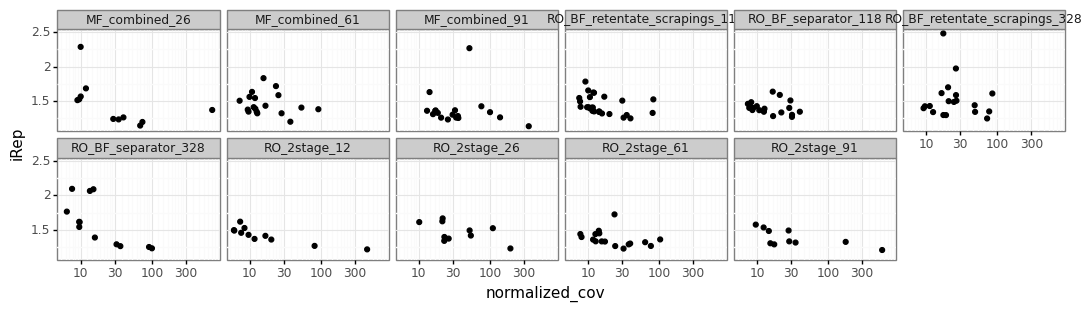

<ggplot: (382854078)>

In [261]:
(ggplot(instrain_iRepFilt_df, aes(x='normalized_cov', y='iRep'))+
geom_point()+
scale_x_log10()+
facet_wrap('sample_id', nrow=2)+
theme_bw()+
theme(figure_size=(13,3)))

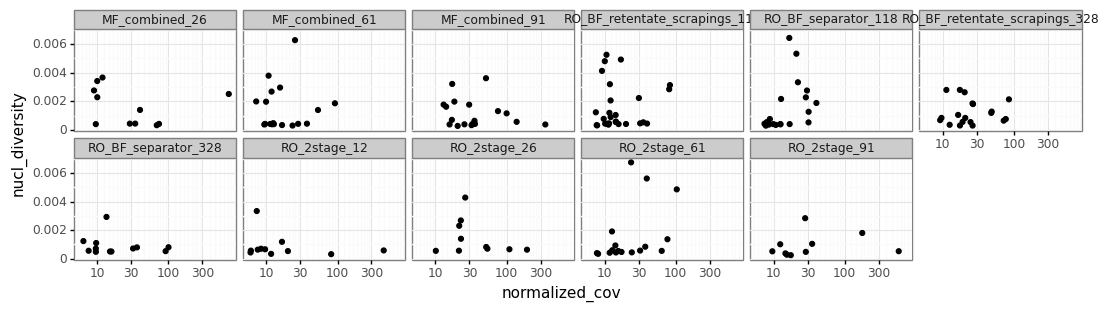

<ggplot: (352113318)>

In [262]:
(ggplot(instrain_iRepFilt_df, aes(x='normalized_cov', y='nucl_diversity'))+
geom_point()+
 scale_x_log10()+
facet_wrap('sample_id', nrow=2)+
theme_bw()+
theme(figure_size=(13,3)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/ge

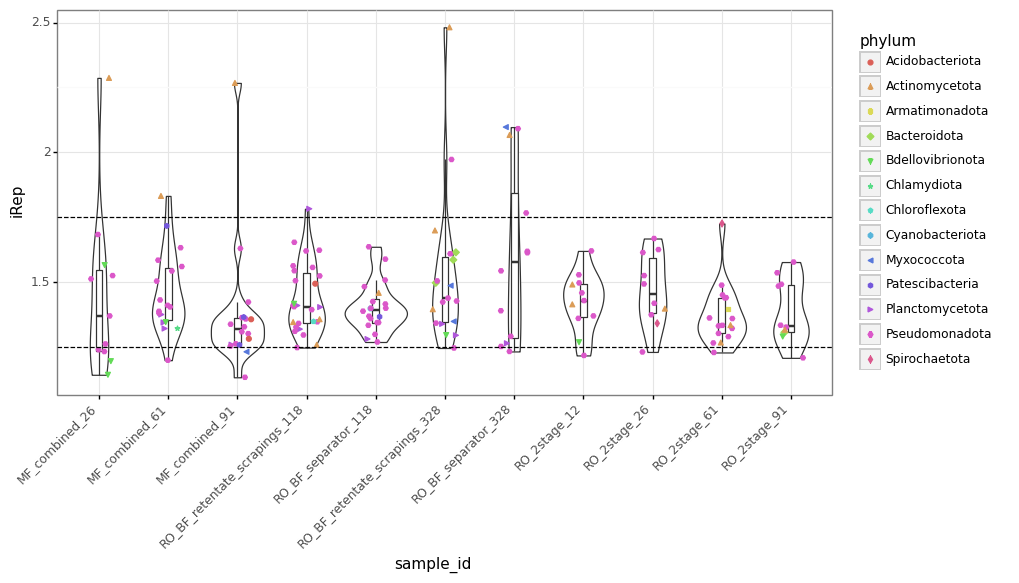

<ggplot: (382201176)>

In [258]:
(ggplot(instrain_iRepFilt_df, aes(x='sample_id', y='iRep'))+
# geom_boxplot(outlier_shape='')+
geom_violin()+
 geom_boxplot(width=0.1, outlier_shape='')+
geom_jitter(aes(color='phylum', shape='phylum'), width=.2)+
geom_hline(yintercept=1.75, linetype='dashed')+
geom_hline(yintercept=1.25, linetype='dashed')+
theme_bw()+
theme(figure_size=(10,5), axis_text_x=element_text(angle=45, hjust=1)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


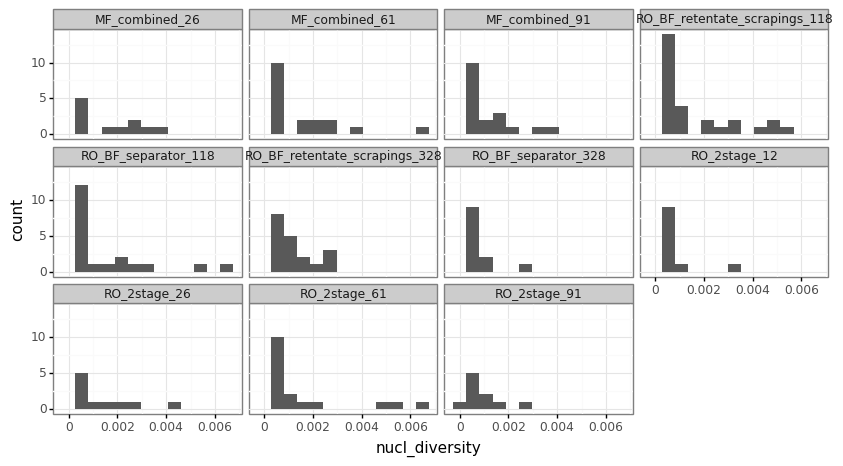

<ggplot: (379421678)>

In [266]:
# distribution of nucl_diversity scores in each sample
(ggplot(instrain_iRepFilt_df[~instrain_iRepFilt_df.nucl_diversity.isna()], aes(x='nucl_diversity'))+
geom_histogram()+
facet_wrap('~sample_id')+
theme_bw()+
theme(figure_size=(10,5)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 19'. Pick better value with 'binwidth'.


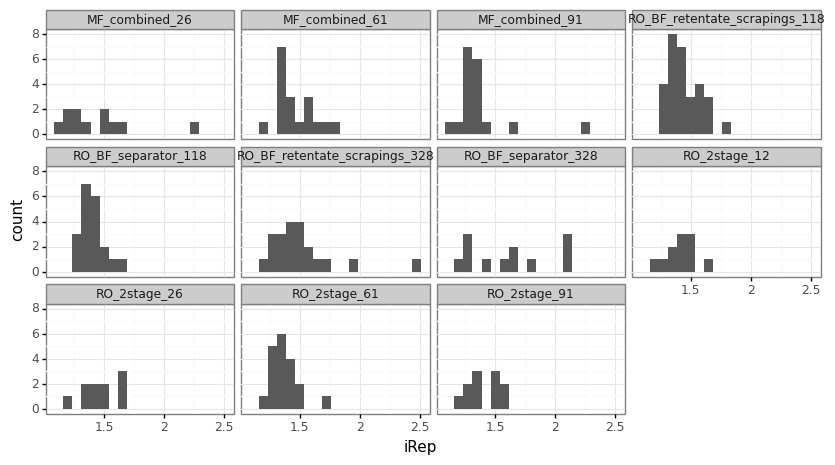

<ggplot: (379605700)>

In [139]:
# distribution of iRep scores in each sample
(ggplot(instrain_df[~instrain_df.iRep.isna()], aes(x='iRep'))+
geom_histogram()+
facet_wrap('~sample_id')+
theme_bw()+
theme(figure_size=(10,5)))

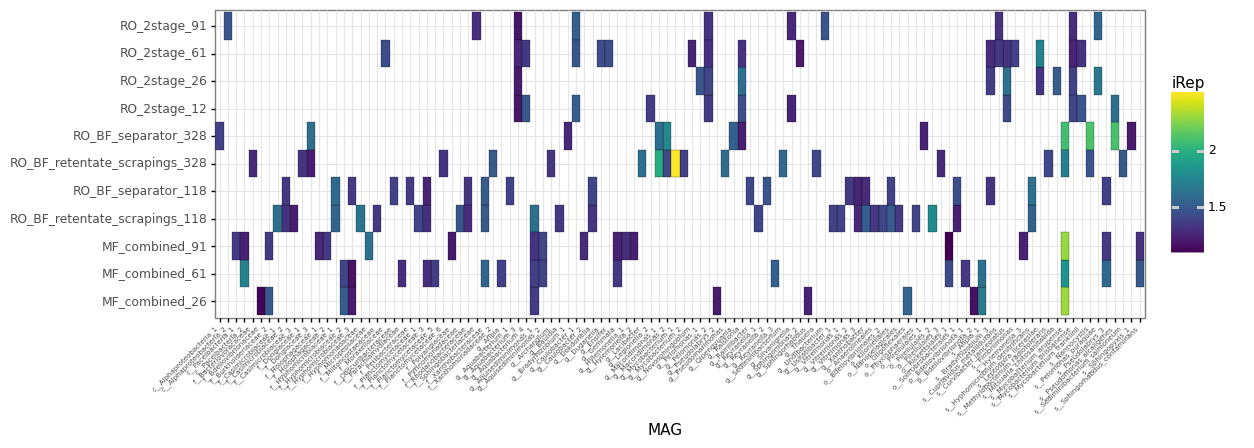

<ggplot: (380348456)>

In [284]:
# plot heatmap of iRep across samples
(ggplot(instrain_iRepFilt_df, aes(y='sample_id', x='sensible_name', fill='iRep'))+

geom_tile(color='black')+
ylab('')+
xlab('MAG')+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1, size=5), figure_size=(12,4)))

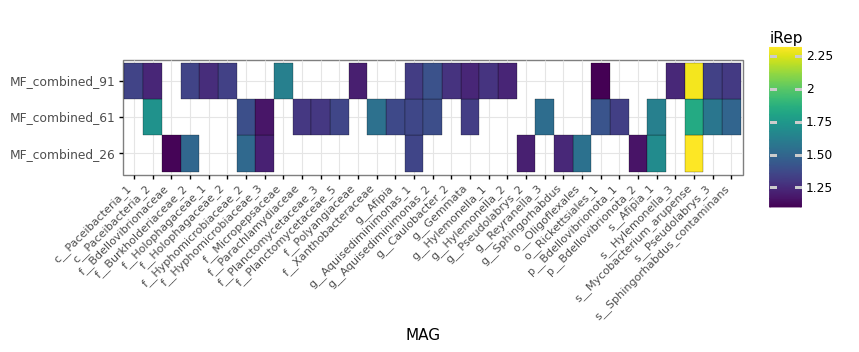

<ggplot: (352117435)>

In [291]:
# just MF
# plot heatmap of iRep across samples
(ggplot(instrain_iRepFilt_df[instrain_iRepFilt_df.sample_id.str.contains("MF")], aes(y='sample_id', x='sensible_name', fill='iRep'))+
geom_tile(color='black')+
ylab('')+
xlab('MAG')+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1, size=8), figure_size=(8,1.5)))

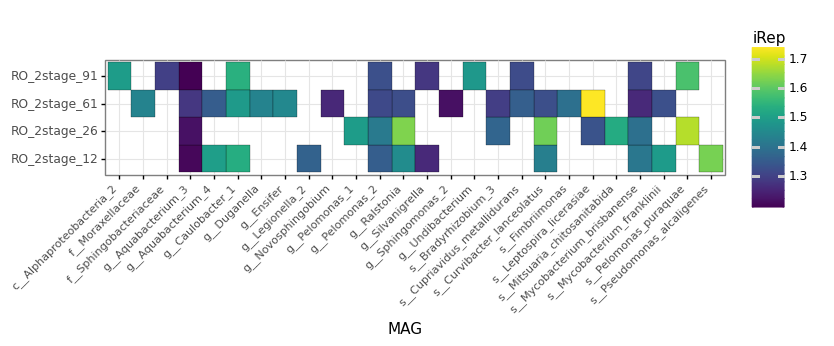

<ggplot: (379513073)>

In [292]:
# just RO
# plot heatmap of iRep across samples
(ggplot(instrain_iRepFilt_df[instrain_iRepFilt_df.sample_id.str.contains("RO_2stage")], aes(y='sample_id', x='sensible_name', fill='iRep'))+
geom_tile(color='black')+
ylab('')+
xlab('MAG')+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1, size=8), figure_size=(8,1.5)))

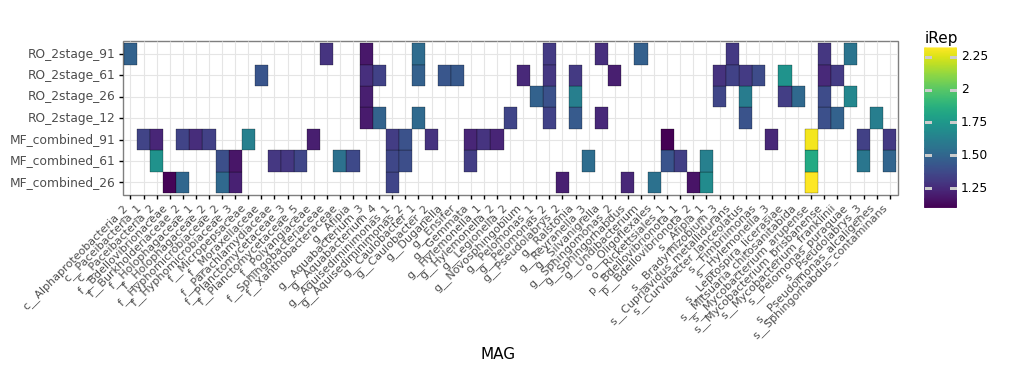

<ggplot: (379797489)>

In [295]:
# just RO
# plot heatmap of iRep across samples
(ggplot(instrain_iRepFilt_df[~instrain_iRepFilt_df.sample_id.str.contains("RO_BF")], aes(y='sample_id', x='sensible_name', fill='iRep'))+
geom_tile(color='black')+
ylab('')+
xlab('MAG')+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1, size=8), figure_size=(10,2)))